In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os


os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "single"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [39]:
errors = []
cl_estimate = []
angles = []
interaction = 2
sigma_abs = 4

start_angle = 0
stop_angle = np.pi

num = 9
angles = np.linspace(start_angle, stop_angle, num)
sigma_vals = sigma_abs*(np.cos(angles+0.001) + 1j*np.sin(angles+0.001))


In [40]:
def abs_drift(z, mass, interaction):
    dr = mass * z + interaction * z * z * z
    return np.abs(dr)  # Example: f(x + iy) = |x + iy|^2 = x^2 + y^2


100%|██████████| 5000/5000 [00:10<00:00, 470.10it/s]


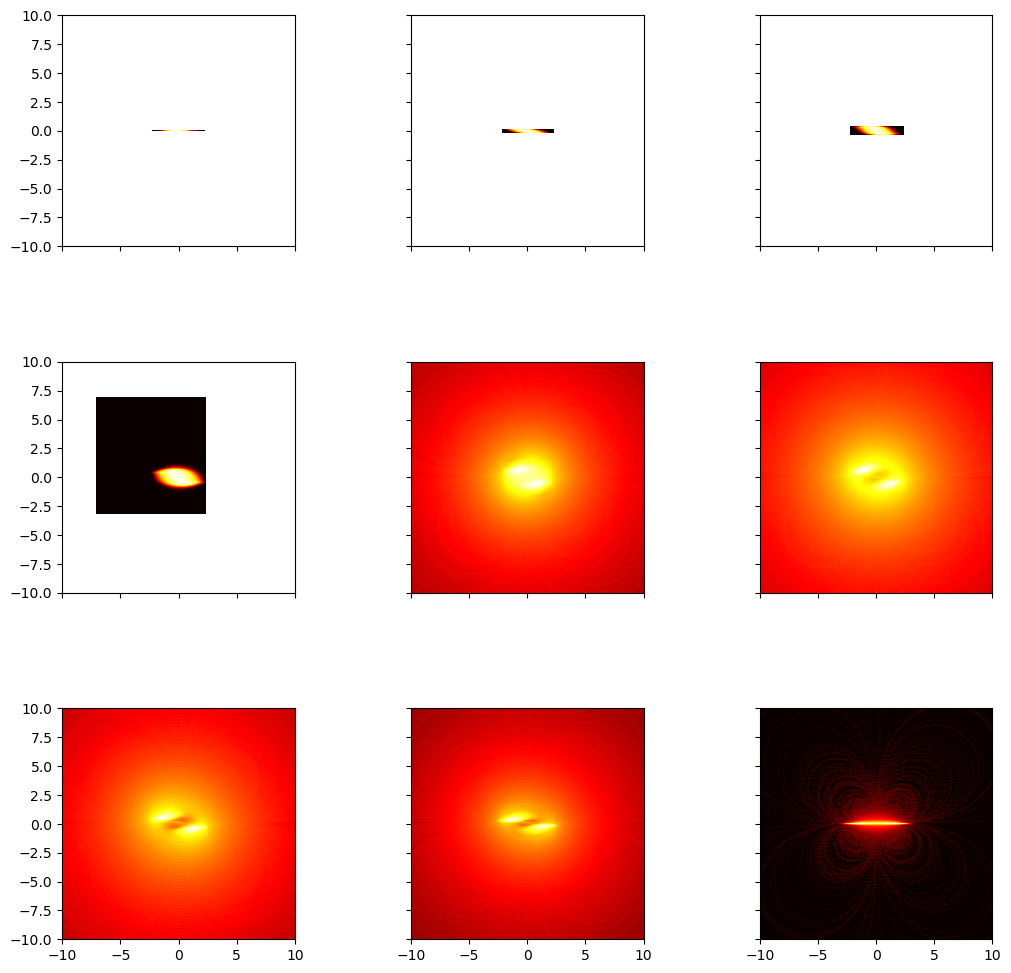

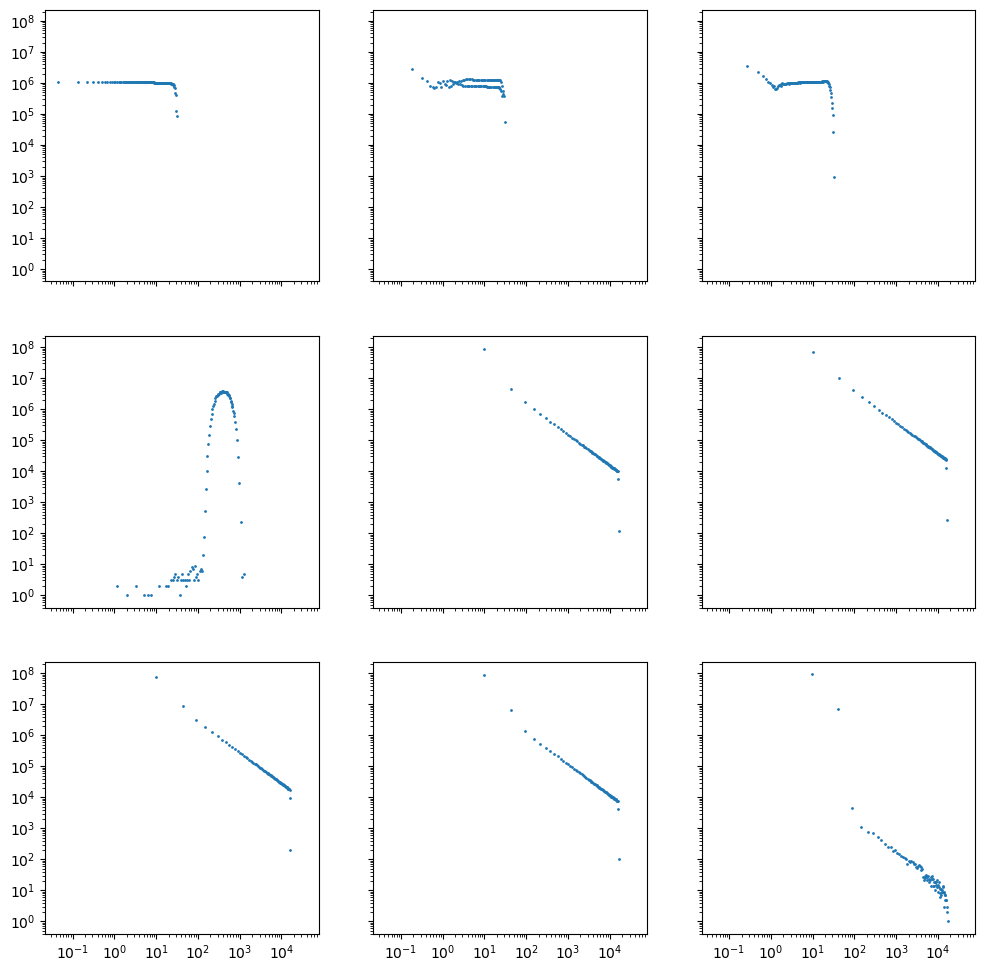

In [ ]:

import matplotlib.pyplot as plt
fig1, ax1es1 = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex=True, sharey=True)
ax1es1 = ax1es1.flatten()
fig1.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

ig1, axes2 = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex=True, sharey=True)
axes2 = axes2.flatten()
fig1.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots


import numpy as np
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm

for idx, (ax1, ax2, sigma) in enumerate(zip(ax1es1, axes2, (sigma_vals))):
    config = Config(dt = 5e-2, trajs = int(2e4), dims = [1], mass_real = sigma, interaction = interaction, ada_step = True)
    sim = ComplexLangevinSimulation(config)
    
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=True, thermal_time=0, auto_corr=0.0)

    for _ in tqdm(range(int(5e3))):
        sim.step()
        for name, tr in sim.trackers.items():
            tr.mark_equilibrated_trajs()
            tr.compute()
    sim.finish()
    data = (sim.trackers['1_moment'].history.flatten())
    
    magnitudes = np.abs(data)
    data = data[magnitudes<20]
    # da = np.append([art_dp, -art_dp], da)
    real_parts, imag_parts = data.real, data.imag
    bins = 300
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

    # Plot the heatmap
    ax1.imshow(
        np.log10(heatmap+1).T,
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        origin='lower',
        cmap='hot',
        aspect='auto',
    )

    ax1.set_xlim(-10,10)
    ax1.set_ylim(-10,10)

    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    Z = X + 1j * Y  # Complex grid
    
    F_values = abs_drift(Z, mass=sigma, interaction=sim.interaction)
    F_values_sort, heatmap_sort = zip(*sorted(zip(F_values.flatten(), heatmap.flatten())))
    res_heat = np.reshape(heatmap_sort, newshape=(100, int(len(heatmap_sort)/100))).sum(axis=1)
    F_heat = np.reshape(F_values_sort, newshape=(100, int(len(heatmap_sort)/100))).mean(axis=1)
    ax2.scatter(F_heat, res_heat, s = 1)
    # hist, bins = np.histogram(np.hstack(F_values), bins = 100)
    # ax2.plot( bins[:-1], hist)

    # label = rf"$|\sigma|={{{sigma_abs}}} \quad arg(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"
    # label = rf"$Re (\sigma)={{{np.round(sigma100.real, 2)}}} \quad Im (\sigma)={{{np.round(sigma.imag, 2)}}}$"

    # ax.set_title(label)
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    # ax2.set_xlim(1, int(1e5))
plt.show()

(3.9999980000001667+0.003999999333333367j)


IndexError: list index out of range

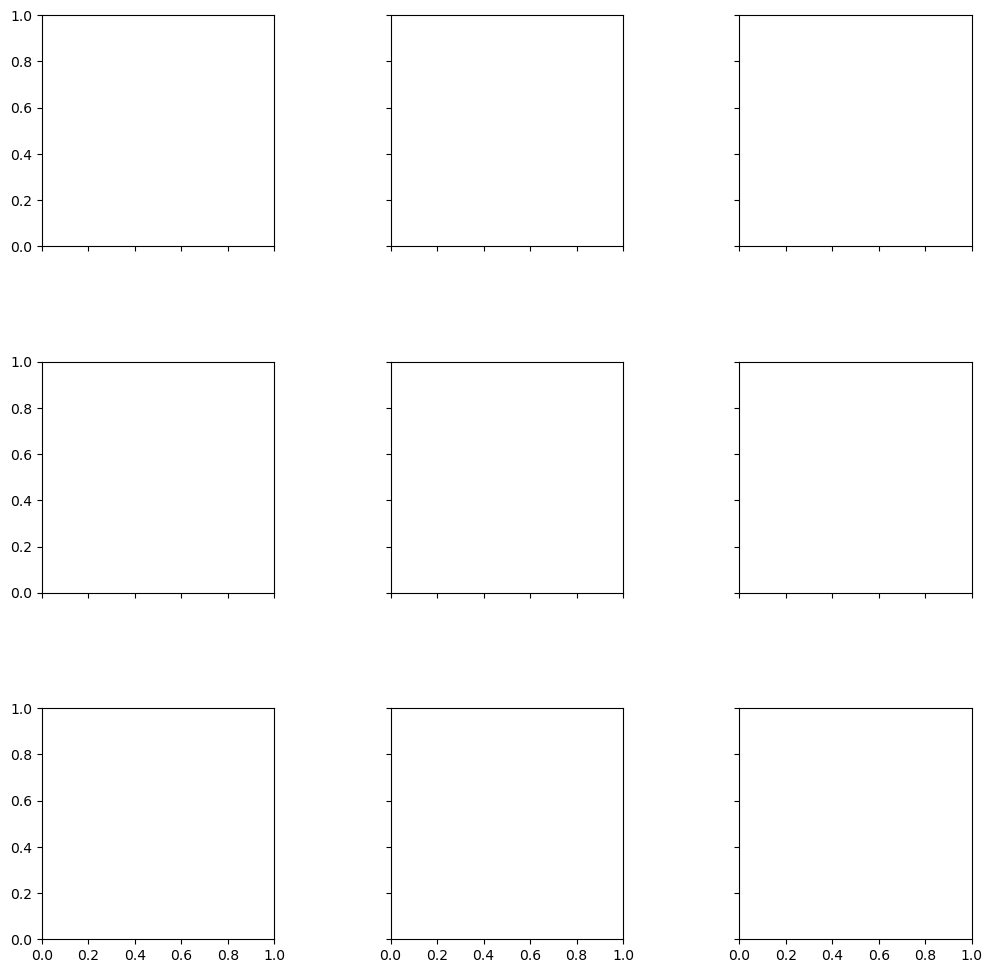

In [42]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

for ax, da, sigma in zip(axes, data, sigma_vals):
    print(sigma)
    magnitudes = np.abs(da)
    art_dp = 10+10j
    # da = np.append([art_dp, -art_dp], da)
    real_parts, imag_parts = da.real, da.imag
    bins = 500
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

    # Plot the heatmap
    ax.imshow(
        np.log10(heatmap+1).T,
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        origin='lower',
        cmap='hot',
        aspect='auto',
    )

    label = rf"$|\sigma|={{{sigma_abs}}} \quad arg(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"
    label = rf"$Re (\sigma)={{{np.round(sigma.real, 2)}}} \quad Im (\sigma)={{{np.round(sigma.imag, 2)}}}$"

    ax.set_title(label)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)


    
plt.show()

(0.7000004761807905+0.7141423761034396j)
(0.46255410152823+0.8865910574551336j)
(0.18527287824067865+0.9826871122531396j)
(-0.1079639209168147+0.994154812783335j)
(-0.391902939698883+0.920006568376212j)
(-0.6420915404629627+0.7666279760522046j)
(-0.8369836489039948+0.5472278971939886j)
(-0.959795287506153+0.28070091927348784j)
(-0.9999500004166653-0.00999983333416633j)


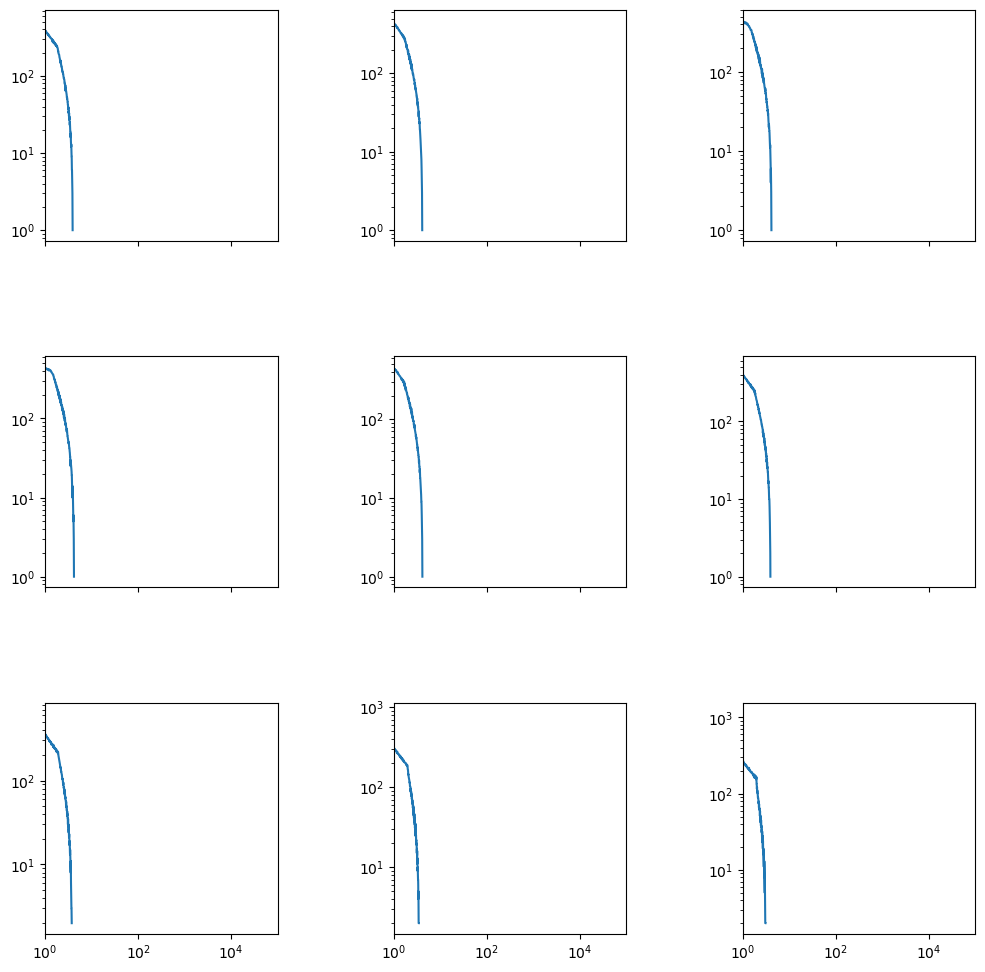

In [ ]:
def abs_drift(z, mass, interaction):
    dr = mass * z + interaction * z * z * z
    return np.abs(dr)  # Example: f(x + iy) = |x + iy|^2 = x^2 + y^2

import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex = True)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

for ax, da, sigma in zip(axes, data, sigma_vals):
    print(sigma)
    magnitudes = np.abs(da)
    da = da[magnitudes <= 20]   
    art_dp = 10+10j
    # da = np.append([art_dp, -art_dp], da)
    real_parts, imag_parts = da.real, da.imag
    bins = 200
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)
    
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    Z = X + 1j * Y  # Complex grid
    F_values = abs_drift(Z, mass=sigma, interaction=sim.interaction)
    hist, bins = np.histogram(np.hstack(F_values), bins = 200)
    ax.plot( bins[:-1], hist)
    # label = rf"$|\sigma|={{{sigma_abs}}} \quad arg(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"
    # label = rf"$Re (\sigma)={{{np.round(sigma.real, 2)}}} \quad Im (\sigma)={{{np.round(sigma.imag, 2)}}}$"

    # ax.set_title(label)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1, int(1e5))
plt.show()

In [ ]:
heatmap.shape

(200, 200)

100%|██████████| 24/24 [00:00<00:00, 37268.90it/s]


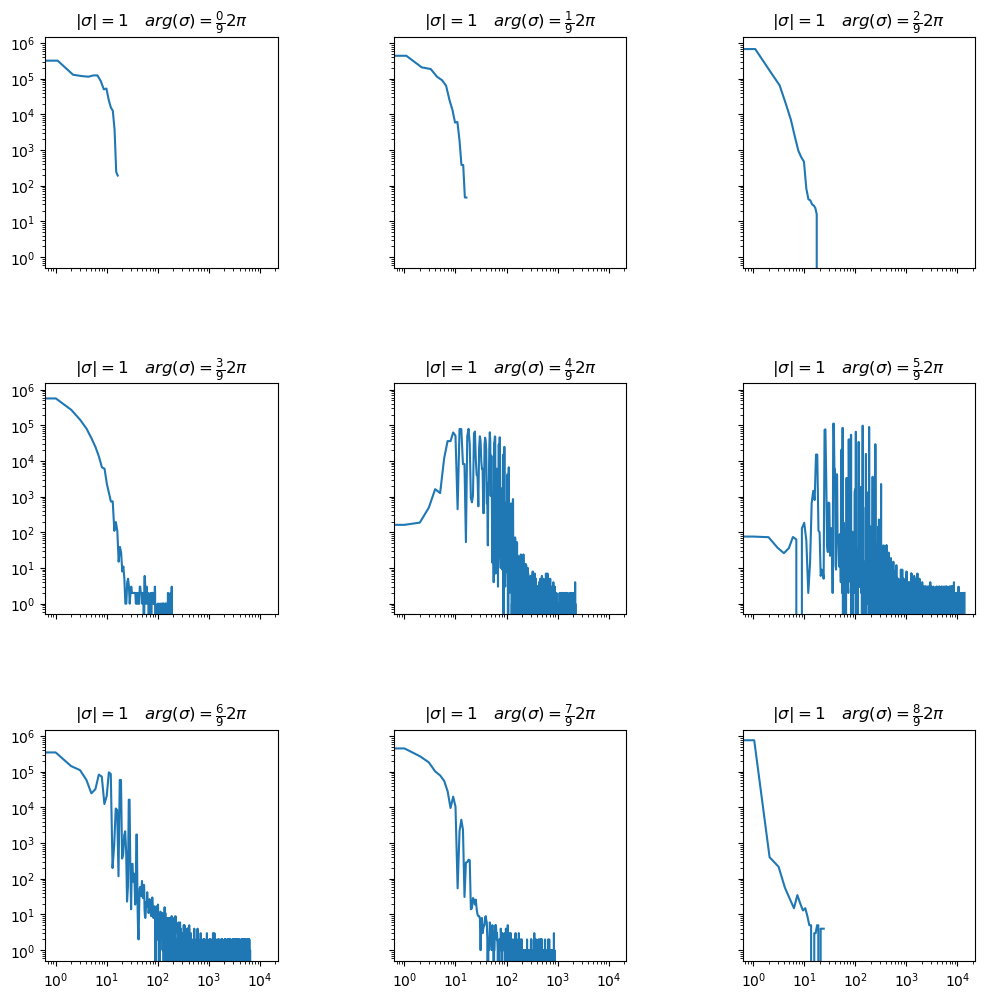

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def abs_drift(z, mass, interaction):
    dr = mass * z + interaction * z * z * z
    return np.abs(dr)  # Example: f(x + iy) = |x + iy|^2 = x^2 + y^2


fig, axes = plt.subplots(int(np.sqrt(num)), int(np.sqrt(num)), figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing between subplots

for idx, da in enumerate(data):
    ax = axes[idx]
    magnitudes = np.abs(da)
    # da = np.append([art_dp, -art_dp], da)
    real_parts, imag_parts = da.real, da.imag
    bins = 50
    heatmap, xedges, yedges = np.histogram2d(real_parts, imag_parts, bins=bins)

    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(x_centers, y_centers)
    Z = X + 1j * Y  # Complex grid
    
    F_values = abs_drift(Z, mass=sigma, interaction=sim.interaction)

    # Create an array of counts for the specified u_values
    u_values = np.linspace(0, F_values.max(), int(F_values.max()))

    counts = []

    # Vectorized approach: loop over each u_val
    for u_val in tqdm(u_values):
        mask = np.abs(F_values - u_val) < 1
        masked_values = heatmap[mask]
        count = np.sum(masked_values)
        counts.append(count)
        
    ax.plot(u_values, counts)
    ax.set_yscale('log')   
    ax.set_xscale('log')   

    label = rf"$|\sigma|={{{sigma_abs}}} \quad arg(\sigma) = \frac{{{idx}}}{{{num}}} 2\pi$"
    ax.set_title(label)
plt.show()

In [ ]:
u_values.max()

34.061206842451995

In [ ]:
# Step 6: Define your real-valued function f(x + iy)
def abs_drift(z, mass, interaction):
    dr = mass * z + interaction * z * z * z
    return np.abs(dr)  # Example: f(x + iy) = |x + iy|^2 = x^2 + y^2

# Step 7: Compute f(x + iy) on the histogram grid
x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X, Y = np.meshgrid(x_centers, y_centers)
Z = X + 1j * Y  # Complex grid
F_values = abs_drift(Z, mass=sigma, interaction=sim.interaction)

# Step 8: Compute u(z) by mapping f(x + iy) results to bins (if needed)
# For example, aggregate P(x, y) weighted by bins in the z-space.


In [ ]:
F_values.max()

34.061206842451995

In [ ]:
import numpy as np
from tqdm import tqdm

# Assuming F_values and P are your 2D arrays
# Example placeholder arrays (adjust according to your actual data)
# Define tolerance
tolerance = 0.01

# Create an array of counts for the specified u_values
u_values = np.linspace(0, 50, 50)

counts = []

# Vectorized approach: loop over each u_val
for u_val in tqdm(u_values):
    mask = np.abs(F_values - u_val) < 0.1
    masked_values = heatmap[mask]
    count = np.sum(masked_values)
    counts.append(count)

# `counts` now holds the summed values for each u_val
counts

100%|██████████| 50/50 [00:00<00:00, 25757.21it/s]


[0.0,
 786634.0,
 49100.0,
 143469.0,
 485314.0,
 217773.0,
 342406.0,
 362780.0,
 334972.0,
 218107.0,
 34076.0,
 208145.0,
 219126.0,
 12239.0,
 218235.0,
 109528.0,
 193672.0,
 159917.0,
 213267.0,
 81911.0,
 232126.0,
 75.0,
 59142.0,
 12809.0,
 188176.0,
 239053.0,
 23.0,
 126087.0,
 116234.0,
 1.0,
 16429.0,
 19255.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

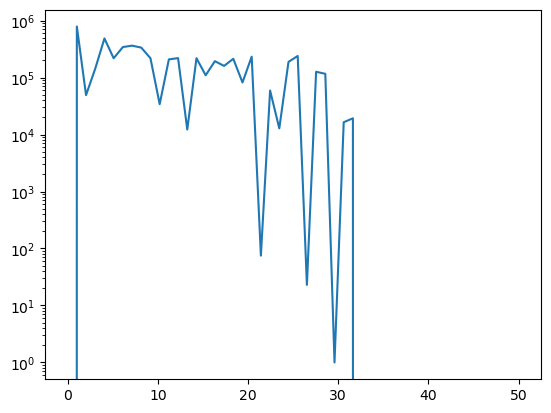

In [ ]:
plt.plot(u_values, counts)
plt.yscale('log')